# Lab 5  - WFST operations

So far we've used WFSTs mainly as a usual structure for encoding and traversing HMMs.  In this lab we'll move away from HMM acoustic modelling and look at how WFST operations can be used to avoid the need for specialised algorithms in speech and language processing.  It is intended to give you insight into how these operations are used to construct HMMs encapsulating langauge model, pronunciation and acoustic modelling assumptions &ndash; the so-called "HCLG" WFST.

This lab will focus on the lexicon transducer, $L$, and grammar transducer, $G$.

We'll use some of the following operations, defined by Openfst:
* `fst.determinize(f)` creates determinized version of `f`
* `fst.compose(f1,f2)` composes FSTs `f1` and `f2`
* `fst.shortestpath(f)` returns the shortest path (in terms of weight) through `f` from the start to a final state
* `f.minimize()` creates minimized version of `f`
* `f.project(project_output=False)` for every arc in `f`, copies the input label to the output label (or vice versa, if `project_output=True`).
* `f.rmepsilon()` removes epsilon transitions &ndash; those arcs where both input and output labels are empty

For efficiency, the compostion of `f1` and `f2` requires either the output arcs of `f1` or input arcs of `f2` to be sorted prior to `compose()` being called.  You can do this by calling `f1.arcsort(sort_type='olabel')` or `f2.arcsort(sort_type='ilabel')`.

The functions above assume that `openfst_python` has been imported as `fst`.  Note that the first three functions above return a new WFST; the others modify the WFST *in place*, meaning that the original WFST is modified directly.

For convenience, we've provided a python module `helper_functions` that provides the `parse_lexicon()` and `generate_symbol_tables()` from the [Lab 1 solutions](https://github.com/Ore-an/asr_lab1/blob/master/asr_lab1_solutions.ipynb).  And here is a function to generate an $L$ transducer:

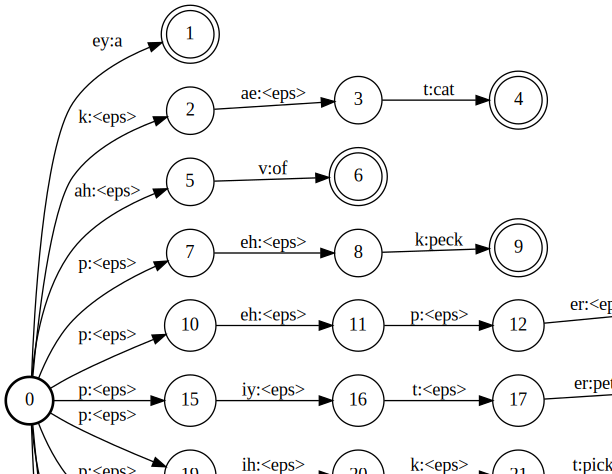

In [1]:
import openfst_python as fst
from helper_functions import parse_lexicon, generate_symbol_tables

lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)  # we won't use state_table in this lab

def generate_L_wfst(lex):
    """ Express the lexicon in WFST form
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
    
    Returns:
        the constructed lexicon WFST
    
    """
    L = fst.Fst()
    
    # create a single start state
    start_state = L.add_state()
    L.set_start(start_state)
    
    for (word, pron) in lex.items():
        
        current_state = start_state
        for (i,phone) in enumerate(pron):
            next_state = L.add_state()
            
            if i == len(pron)-1:
                # add word output symbol on the final arc
                L.add_arc(current_state, fst.Arc(phone_table.find(phone), \
                                                 word_table.find(word), None, next_state))
            else:
                L.add_arc(current_state, fst.Arc(phone_table.find(phone),0, None, next_state))
            
            current_state = next_state
                          
        L.set_final(current_state)
        
    L.set_input_symbols(phone_table)
    L.set_output_symbols(word_table)                      
    
    return L

L = generate_L_wfst(lex)
L.arcsort()

For the exercises, here are two functions to generate linear WFSTs for an arbitary sequence of phones or words.  (Yes, they are really just variants of the same function!)

In [2]:
def generate_linear_phone_wfst(phone_list):
    
    P = fst.Fst()
    
    current_state = P.add_state()
    P.set_start(current_state)
    
    for p in phone_list:
        
        next_state = P.add_state()
        P.add_arc(current_state, fst.Arc(phone_table.find(p), phone_table.find(p), None, next_state))
        current_state = next_state
        
    P.set_final(current_state)
    P.set_input_symbols(phone_table)
    P.set_output_symbols(phone_table)
    return P
    
def generate_linear_word_wfst(word_list):
    
    W = fst.Fst()
    
    current_state = W.add_state()
    W.set_start(current_state)
    
    for w in word_list:
        
        next_state = W.add_state()
        W.add_arc(current_state, fst.Arc(word_table.find(w), word_table.find(w), None, next_state))
        current_state = next_state
        
    W.set_final(current_state)
    W.set_input_symbols(word_table)
    W.set_output_symbols(word_table)
    return W

## Exercises

1. Suppose you are given a sequence of phones, in the form `['p','ih','k','t']`, and the $L$ transducer created above.  Write a function that returns the matching word from the lexicon for any given phone sequence, or else `None` if no matching word is found.   Write two functions:
  1. That works for $L$ as provided by the code above
  2. That works only on a determinized version of $L$ &ndash; and test it on the output of `fst.determinize(L)`
  
 This should enable you to see why determinization is a very useful WFST operation!
  


In [3]:
import math

def transduce_sequence_nondet(f, in_seq):
    """Return transduced sequence given input sequence and non determinized FST
    
        Args:
            f (fst.Fst()): a non determinized FST
            in_seq (list[str]): the sequence of strings to transduce
            
        Returns:
            out_seq (list[str]): the sequence of transduced symbols
            """
    
    seq_len = len(in_seq)
    in_seq.append('<EOS>') # adding a padding symbol at the end for possible final eps traversal
    eps = f.input_symbols().find('<eps>')
    queue = [(f.start(), 0, [])]  # the tuple is (state, index in input sequence, output)
    
    while queue:
        curr_state, i, output = queue.pop(0) # pop first element in list
        
        if i <= seq_len:  # <= because we could traverse epsilons even when the input sequence ended
            label = f.input_symbols().find(in_seq[i])  # transform label into index in table
            for arc in f.arcs(curr_state):
                if arc.ilabel == label:
                    new_output = output + [arc.olabel]
                    queue.append((arc.nextstate, i+1, new_output))
                elif arc.ilabel == eps and arc.nextstate != curr_state:
                    new_output = output + [arc.olabel]
                    queue.append((arc.nextstate, i, new_output))  # we're not advancing in the input sequence because it's epsilon
                        
        if i == seq_len:
            final_weight = float(f.final(curr_state))
            if final_weight != math.inf: # if this is a final state
                out_seq = [f.output_symbols().find(w) for w in output if w != eps]  # find the labels in the table, remove epsilons
                return out_seq
            
        
    print("Can't transduce the sequence with provided FST")  # return exits the function, so this is printed only when the stack is empty and we didn't find a path 

In [4]:
seq = ['p','ih','k','t']
print(transduce_sequence_nondet(L, seq))

['picked']


In [5]:
def transduce_sequence_det(f, seq):
    """Return transduced sequence given input sequence and determinized FST
    
        Args:
            f (fst.Fst()): a determinized FST
            in_seq (list[str]): the sequence of strings to transduce
            
        Returns:
            out_seq (list[str]): the sequence of transduced symbols
            """
    
    seq_len = len(seq)
    eps = f.input_symbols().find('<eps>')
    curr_state = f.start()
    output = []
    
    for i in range(seq_len):
        found = False
        label = f.input_symbols().find(seq[i])
        for arc in f.arcs(curr_state):
            if arc.ilabel == label:
                output += [arc.olabel]
                curr_state = arc.nextstate
                found = True
                break  # no need to keep going through other arcs, as it's determinized
        if not found:
            print("Can't transduce the sequence with provided FST")
                
    final_weight = float(f.final(curr_state))
    if final_weight != math.inf: # if this is a final state
        out_seq = [f.output_symbols().find(w) for w in output if w != eps]  # find the labels in the table, remove epsilons
        return out_seq
    else:  
        print("Can't transduce the sequence with provided FST")

In [6]:
seq = ['p','ih','k','t']
Ldet = fst.determinize(L)
print(transduce_sequence_det(Ldet, seq))

['picked']


2. WFST composition allows you to achieve the same result much more easily.  Create a linear WFST, $P$, corresponding to a string of phones, and compute $P \circ L$.  Then use the projection and epsilon removal operations to display just the matching word.

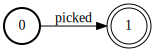

In [7]:
seq = ['p','ih','k','t']
P = generate_linear_phone_wfst(seq)
P.arcsort(sort_type='ilabel')
comp = fst.compose(P, L)
comp.project(project_output=True).rmepsilon()

3. Modify your lexicon WFST slightly to allow a list of phones to be "decoded" to a sequence of multiple words from the lexicon, using composition.  Try it with `['p','eh','k','ah','v','p','iy','t','er']`.  

In [8]:
# this modified the Lexicon WFST directly - you could have done it more simply by adding
# extra code to the generate_L_wfst() function above

start_state = L.start()
for state in L.states():
    if float(L.final(state)) != math.inf:
        L.add_arc(state, fst.Arc(0, 0, None, start_state))  # add arc to start
Ldet = fst.determinize(L)

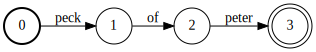

In [9]:
seq = ['p','eh','k','ah','v','p','iy','t','er']
P = generate_linear_phone_wfst(seq)
P.arcsort(sort_type='ilabel')
comp = fst.compose(P, L)
comp.project(project_output=True).rmepsilon()

4. Now solve the reverse problem: create a word-sequence WFST, $W$, and use composition to expand it into a sequence of phones.

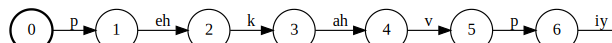

In [10]:
seq = ['peck', 'of', 'peter']
W = generate_linear_word_wfst(seq)
W.arcsort(sort_type='olabel')
comp = fst.compose(L, W)
comp.project().rmepsilon()

5. Another advantage of WFST composition to solve these kind of problems are that it is easy to encode uncertainty in the input (a bit like in real ASR).  For example, consider this WFST, in which the multiple arcs denote alternative phone transcriptions from the acoustic model:

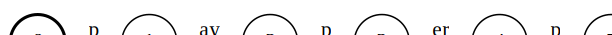

In [11]:
def create_alt_phone_wfst(phone_alternatives):
    
    P = fst.Fst()
    
    current_state = P.add_state()
    P.set_start(current_state)
    
    for alt in phone_alternatives:
        
        next_state = P.add_state()
        for p in alt:
            if p=='*':
                P.set_final(current_state)
            else:
                P.add_arc(current_state, fst.Arc(phone_table.find(p), phone_table.find(p), None, next_state))
        current_state = next_state
        
    P.set_final(current_state)
    P.set_input_symbols(phone_table)
    P.set_output_symbols(phone_table)
    return P    
    
altP = create_alt_phone_wfst([['p'],['ay'],['p'],['er'],['p'],['eh','ih'],['k'],['t','<eps>'],['ah','<eps>'],['l','v','*'],['d','*']])
altP

  Again, perform composition with your $L$ from Question 3, and observe the result.  (Notice particularly what happens to the `<eps>` transitions during composition.  

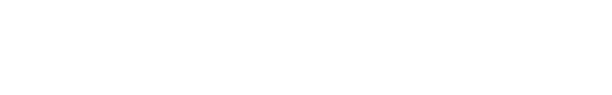

In [12]:
altP.arcsort()
comp = fst.compose(altP, L)
comp

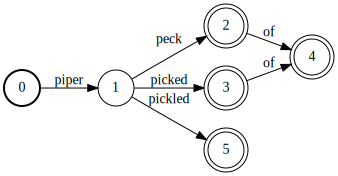

In [13]:
uncertainP = comp.project(True).rmepsilon()
uncertainP

6. We could have added weights to the arcs of the WFST above to describe the probability of the phone alternatives given by the acoustic model &ndash; this would have enabled you to find the most likely sequence of words.  Without this information, let's instead use a $G$ WFST to find the most likely sequence.  Let's assume that a word sequence taken from the passage "peter piper picked a peck of pickled peppers" is most likely.  Design a $G$ WFST that accepts any sequence of words from the lexicon, but adds a cost of 1.0 to any word transition not in the passage.  Given $G$, use composition to recover the most likely word sequence from the uncertain $P$.

**Note on this solution**

Peter and Andrea independently came up with solutions to this question.  It is well worth looking at both!

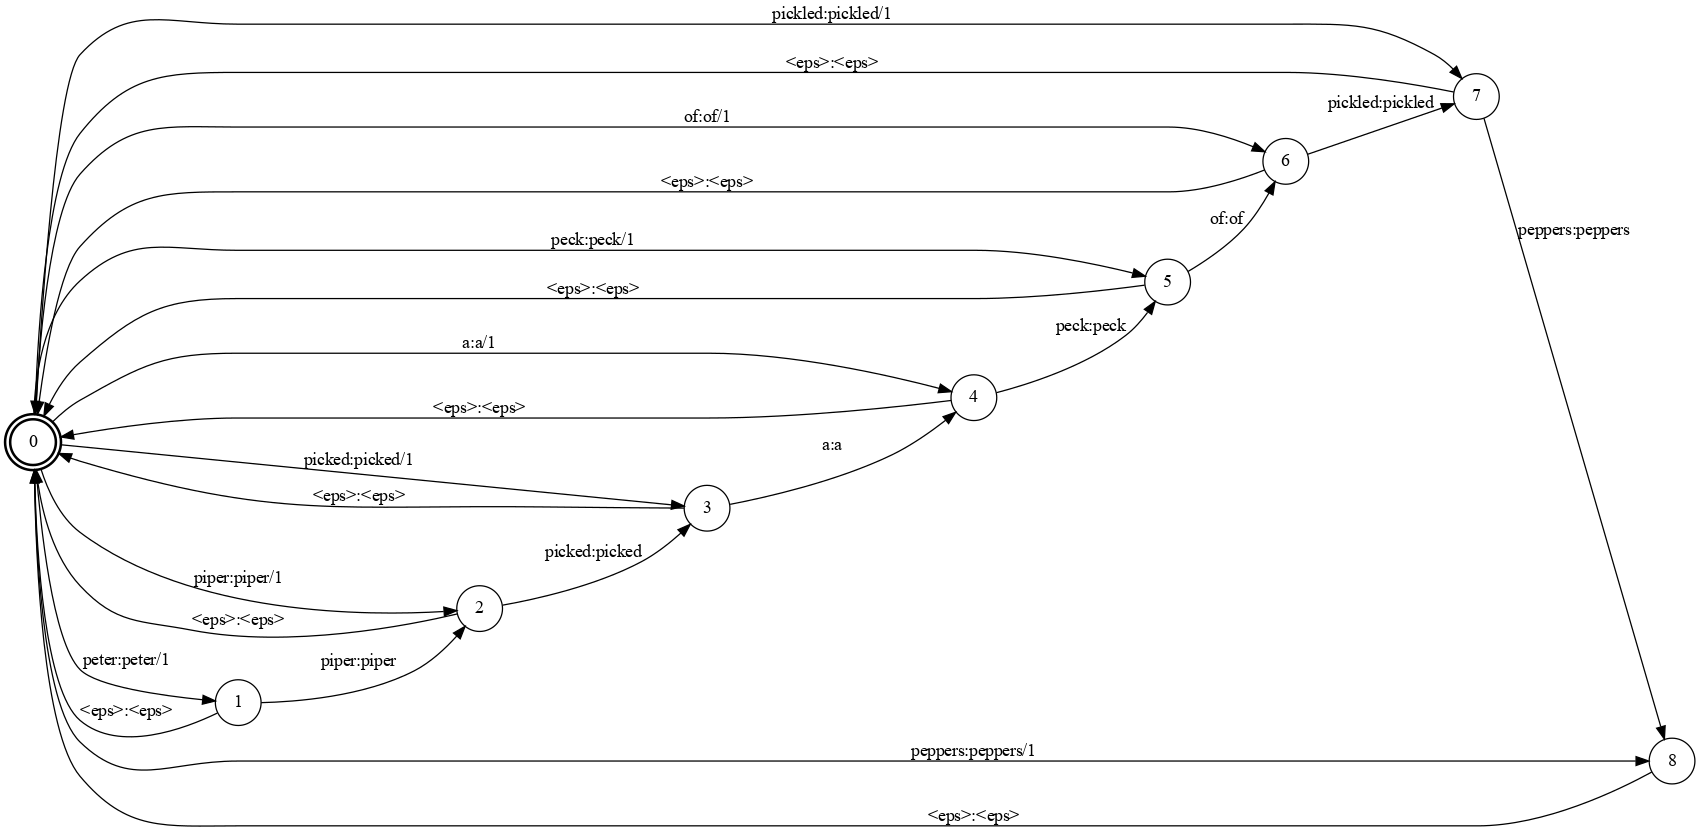

In [22]:
def generate_G_wfst_peter(wseq):
    
    G = fst.Fst()
    
    start_state = G.add_state()
    G.set_start(start_state)
    
    prev_state = None
    
    for w in wseq.split():
        
        current_state = G.add_state()
        
        # add transition from the start with cost 1
        G.add_arc(start_state, fst.Arc(word_table.find(w), word_table.find(w), 1.0, current_state))
        
        # arc from previous word with cost of zero
        if prev_state:
            G.add_arc(prev_state, fst.Arc(word_table.find(w), word_table.find(w), 0, current_state))
        
        # <eps> transition back to the start
        G.add_arc(current_state, fst.Arc(0, 0, 0, start_state))
    
        prev_state = current_state
    
    G.set_final(start_state)
        
    G.set_input_symbols(word_table)
    G.set_output_symbols(word_table)  
 
    return G

string = "peter piper picked a peck of pickled peppers"
G = generate_G_wfst_peter(string)
G


# We need special code to display the higher-resolution WFSTs inside Jupyter notebook
from subprocess import check_call
from IPython.display import Image
G.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

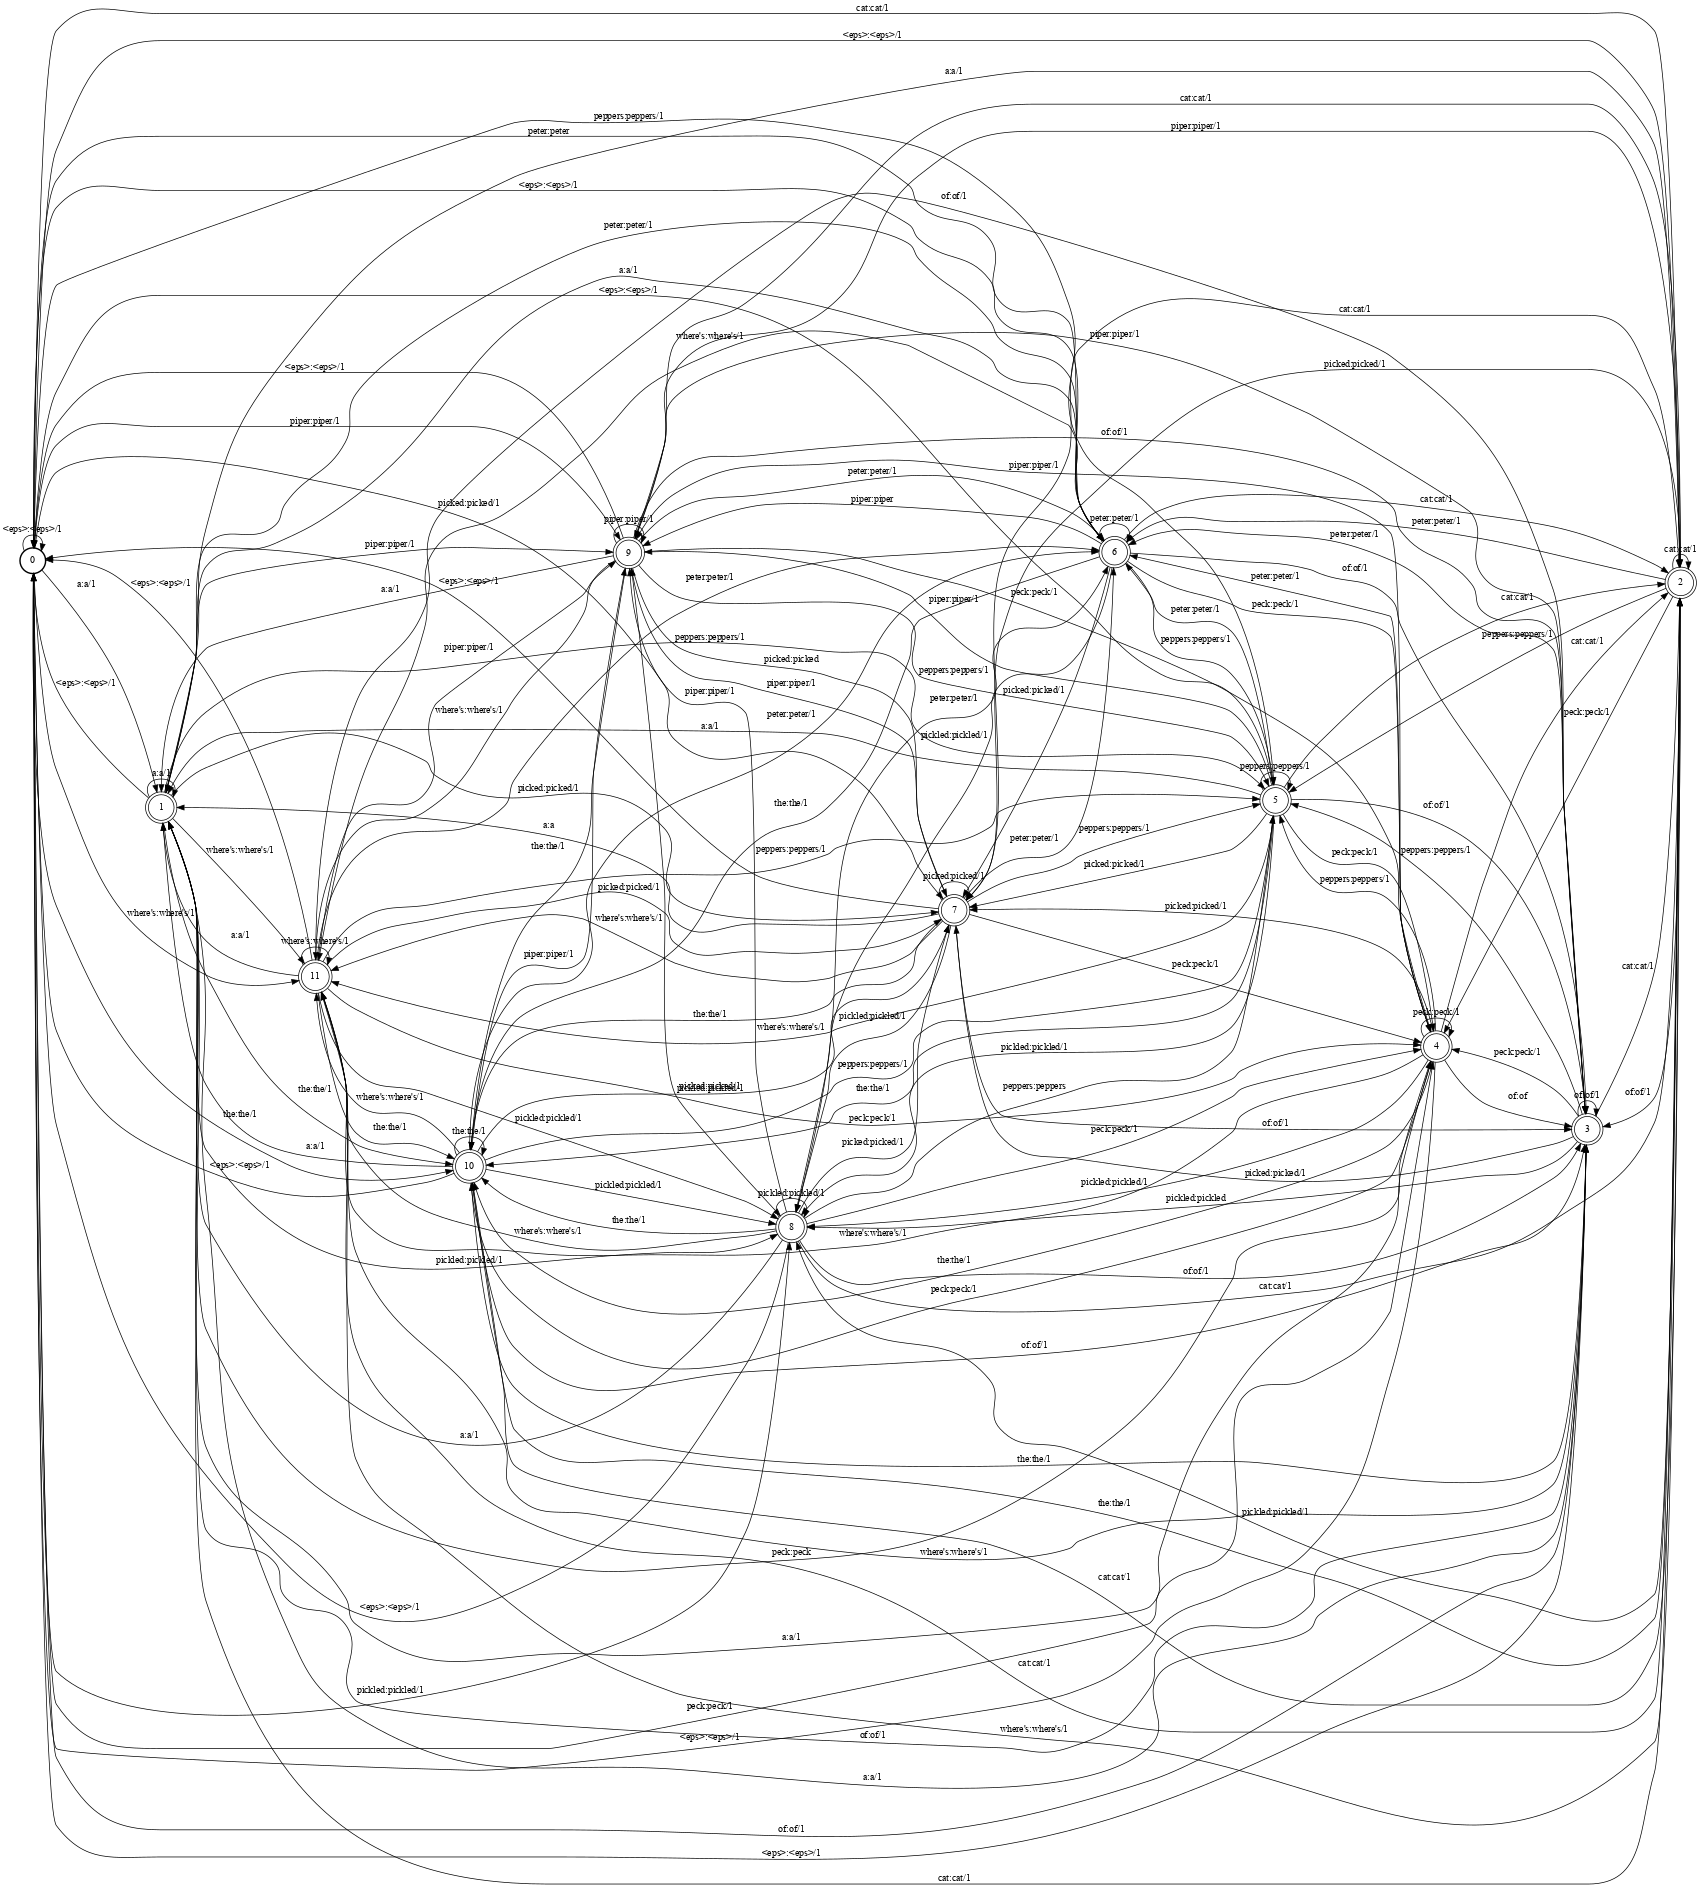

In [23]:
def generate_G_wfst_andrea(wseq):
    G = fst.Fst()
    
    word2state = {} # we will map each word in the lexicon to a state
    state2word = {} # and vice-versa; note this is different from the symbol table mapping
    
    # create a single start state
    start_state = G.add_state()
    G.set_start(start_state)
    
    word2state['<s>'] = start_state  # we're using a start-of-sentence token to not overload epsilon
    state2word[start_state] = '<eps>'  # epsilon is fine when we're looking up the state to put a label on the arc
    
    wseq = '<s> ' + wseq
    
    for word in lex.keys():
        idx = G.add_state()
        word2state[word] = idx 
        state2word[idx] = word
        
    bigrams = [w for w in zip(wseq.split(" ")[:-1], wseq.split(" ")[1:])] # zipping together the list with itself with offset 1
    passage_state_trans = [(word2state[x], word2state[y]) for x,y in bigrams]  # state indexes for transitions existing in the passage, the ones we don't have to penalize
    
    for state1 in G.states():
        if state1 != start_state:
            G.set_final(state1)
        for state2 in G.states():
            if (state1, state2) in passage_state_trans:
                weight = 0
            else:
                weight = 1.0
            word = state2word[state2]
            label = word_table.find(word)

            G.add_arc(state1, fst.Arc(label, label, weight, state2))
    G.set_input_symbols(word_table)
    G.set_output_symbols(word_table)
    return G

string = "peter piper picked a peck of pickled peppers"
G2 = generate_G_wfst_andrea(string)
G2 = fst.determinize(G2)
G2

# We need special code to display the higher-resolution WFSTs inside Jupyter notebook
from subprocess import check_call
from IPython.display import Image
G2.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

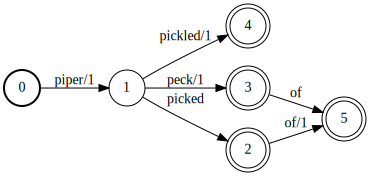

In [16]:
# Composition with Peter's G wfst

G.arcsort(sort_type='olabel')
comp = fst.compose(uncertainP, G)
comp.rmepsilon()

# Note that by default when the weight is 0 it's not printed out in the graph
# so the arcs that don't have a 1 are the most probable (log(0) > log(-1))

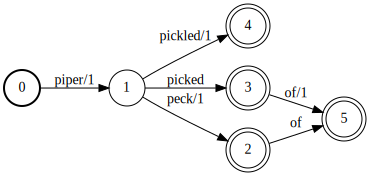

In [17]:
# Composition with Andrea's G wfst - notice how the results are the same
# even thought the G wfsts are very different.

G2.arcsort(sort_type='olabel')
comp2 = fst.compose(uncertainP, G2)
comp2.rmepsilon()

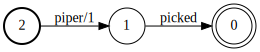

In [18]:
fst.shortestpath(comp)

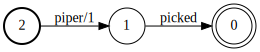

In [19]:
fst.shortestpath(comp2)

## If you have more time

Use WFST composition to implement a "predictive text"-style algorithm, that, given a partial phone sequence such as `['p']` or `['p','ih']`, returns a WFST giving all matching words.  You'll need to make some special modifications to $P$ or $L$, or both. On a determinized $L$ transducer this is a highly efficient way of solving this problem.

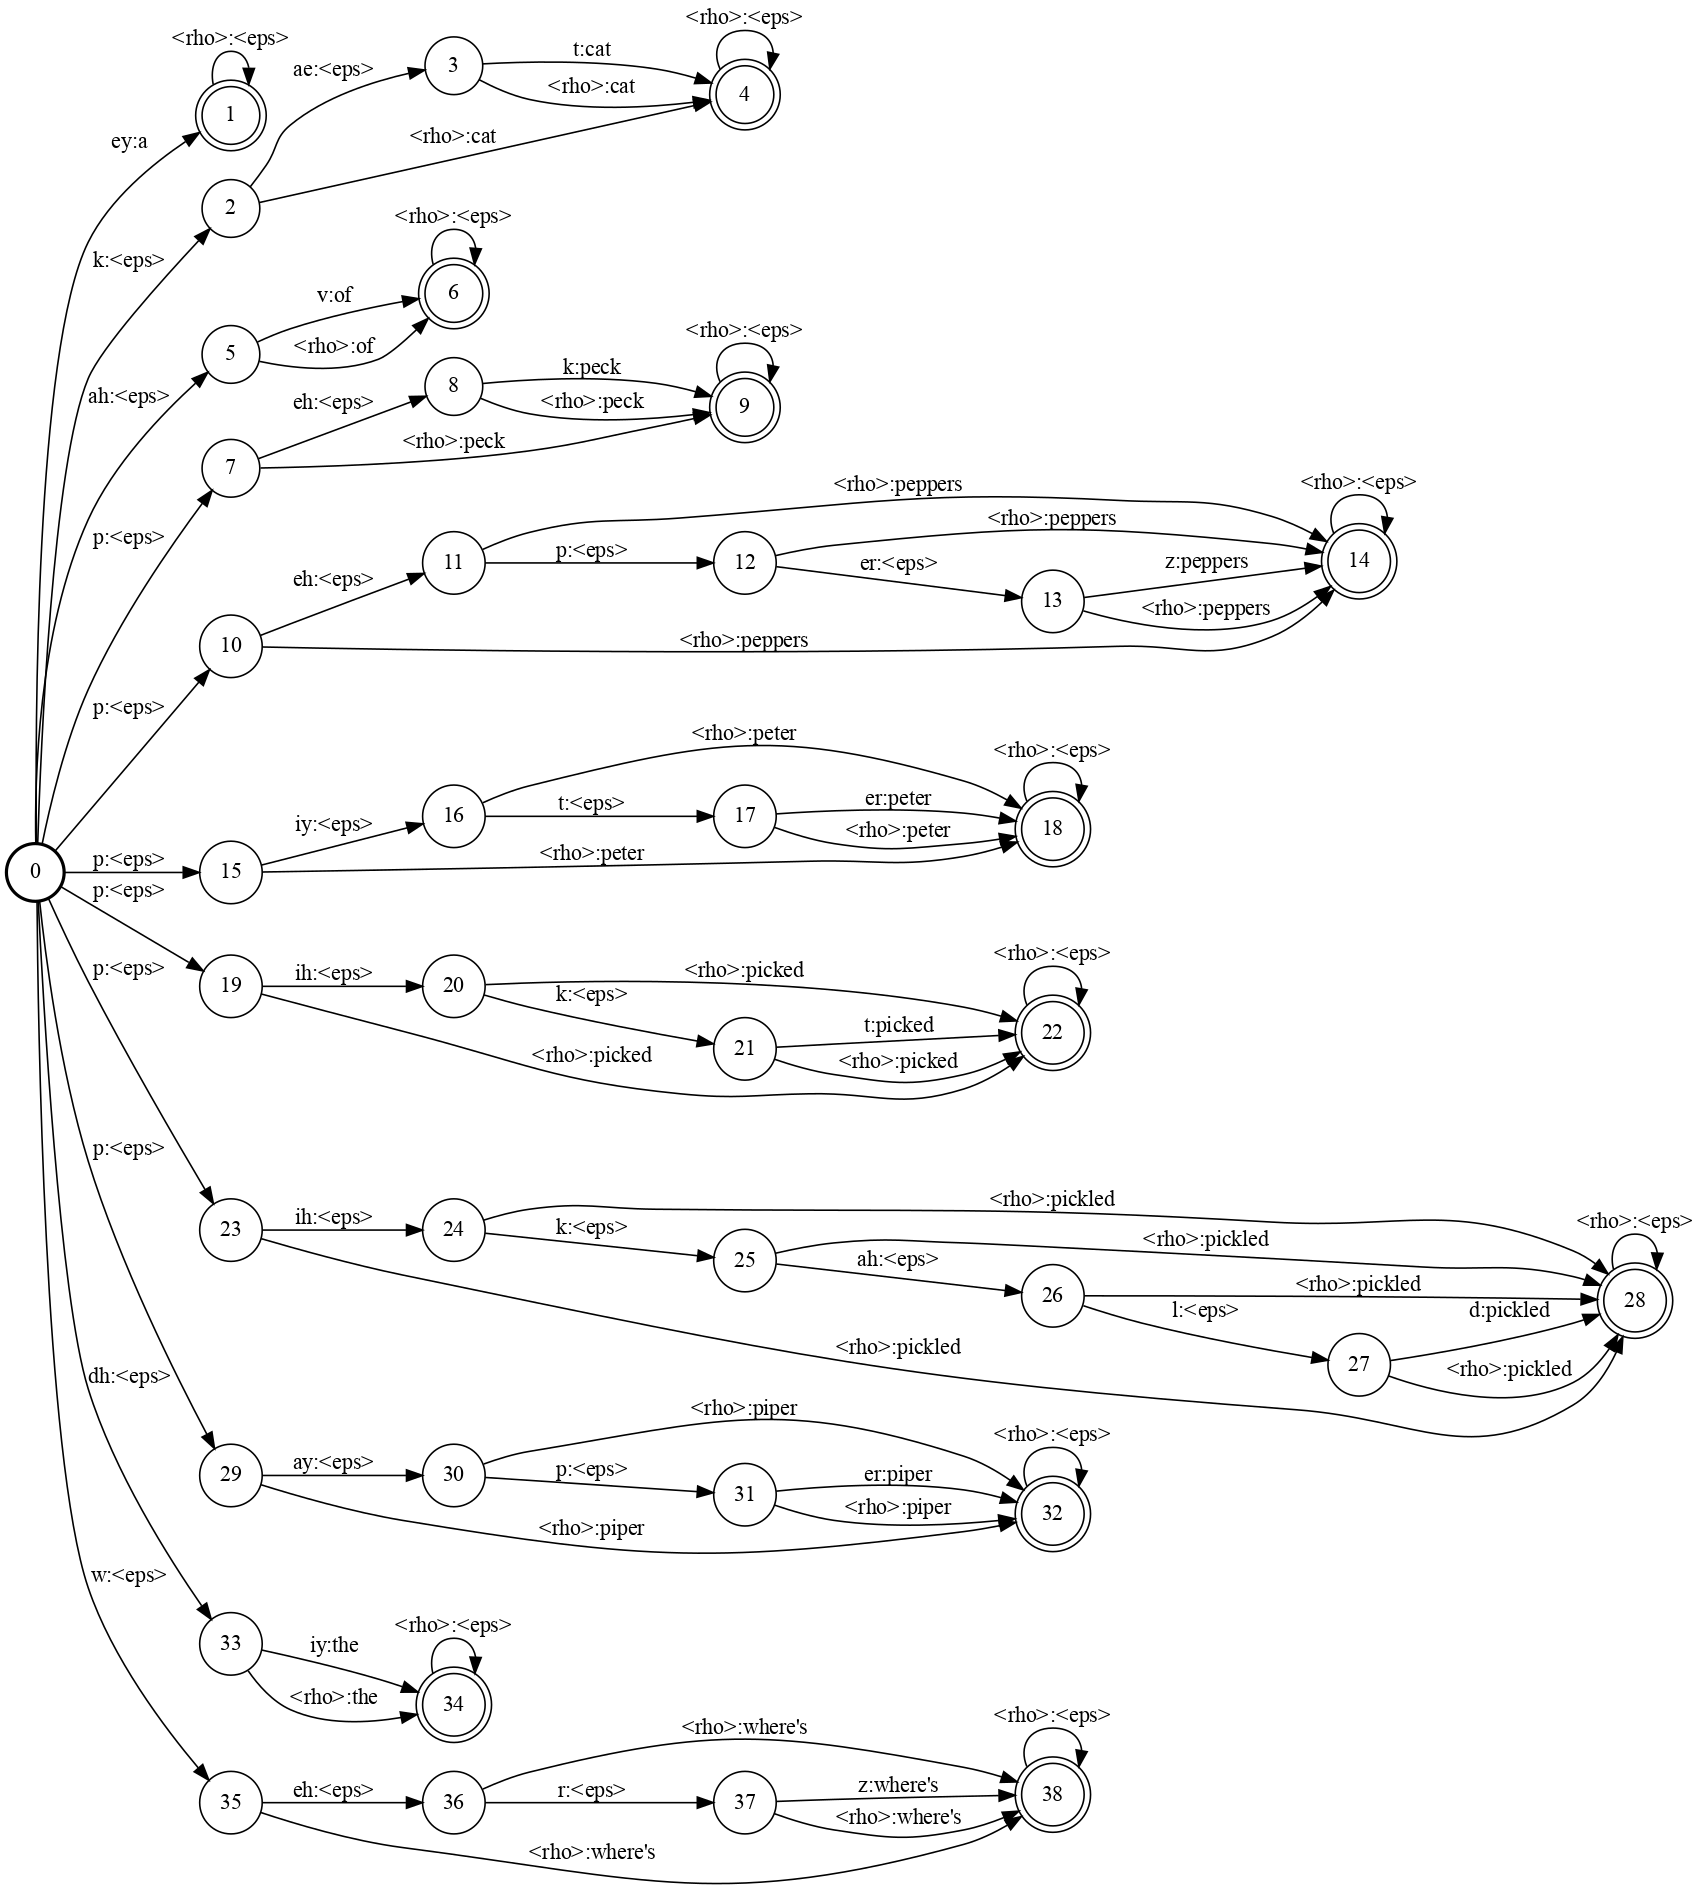

In [24]:
# There are very many ways this problem can be solved. Our skeleton code add extra arcs with 
# special <rho> symbol. This symbol will represent unterminated sequences, and will be transduced
#  to words to be output at every intermediate state.
# The same <rho> symbol is added the end of the partial pronunciation.


# In a real application, the lexicon would be determinised *before* the <rho> arcs are added

def generate_predictive_L_wfst(lex):
    """ express the lexicon in WFST form s.t. composition with partial sequence gives matching words
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
    
    Returns:
        the constructed WFST
    
    """
    Lpred = fst.Fst()
    rho = phone_table.add_symbol('<rho>')
    # create a single start state
    start_state = Lpred.add_state()
    Lpred.set_start(start_state)
    
    for (word, pron) in lex.items():
        state_list = []
        current_state = start_state
        for (i,phone) in enumerate(pron):
            next_state = Lpred.add_state()
            state_list.append(next_state)
            
            if i == len(pron)-1:
                # add word output symbol on the final arc
                Lpred.add_arc(current_state, fst.Arc(phone_table.find(phone), \
                                                 word_table.find(word), None, next_state))
            else:
                Lpred.add_arc(current_state, fst.Arc(phone_table.find(phone), 0, None, next_state))
            
            current_state = next_state

        Lpred.set_final(current_state)
        for state in state_list:
            if state != current_state:
                Lpred.add_arc(state, fst.Arc(phone_table.find('<rho>'), word_table.find(word), None, current_state))
            else:
                Lpred.add_arc(state, fst.Arc(phone_table.find('<rho>'), 0, None, current_state)) # in the final state the word was already output, so no word on output
        
    Lpred.set_input_symbols(phone_table)
    Lpred.set_output_symbols(word_table)                      
    
    return Lpred

Lpred = generate_predictive_L_wfst(lex)
Lpred.arcsort()


# We need special code to display the higher-resolution WFSTs inside Jupyter notebook
from subprocess import check_call
from IPython.display import Image
Lpred.draw('tmp.dot', portrait=True)
check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
Image(filename='tmp.png')

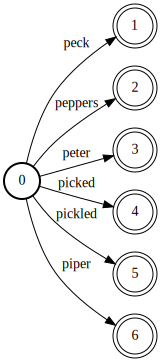

In [26]:
seq = ['p']
seq += ['<rho>']
Ppred = generate_linear_phone_wfst(seq)
Ppred.arcsort(sort_type='ilabel')
comp = fst.compose(Ppred, Lpred)
comp.project(True).rmepsilon()